## About WIS
Good ressources:
-  Supplement of Cramer et al.
- code cramer et al. here https://github.com/reichlab/covid19-forecast-evals
- obviously https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008618#sec015
- [git clone https://github.com/adrian-lison/interval-scoring.git](https://github.com/adrian-lison/interval-scoring/tree/master) Adrian Lison's code for WIS
- https://epiforecasts.io/scoringutils/ Scoring utils package -- perhaps best to use ?

In [23]:
from interval_scoring import scoring
import pandas as pd
import numpy as np
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

datetime.date(2023, 5, 20)

In [130]:
pd.DataFrame.reset_index?

Signature:
pd.DataFrame.reset_index(
    self,
    level: 'IndexLabel' = None,
    drop: 'bool' = False,
    inplace: 'bool' = False,
    col_level: 'Hashable' = 0,
    col_fill: 'Hashable' = '',
    allow_duplicates: 'bool | lib.NoDefault' = <no_default>,
    names: 'Hashable | Sequence[Hashable]' = None,
) -> 'DataFrame | None'
Docstring:
Reset the index, or a level of it.

Reset the index of the DataFrame, and use the default one instead.
If the DataFrame has a MultiIndex, this method can remove one or more
levels.

Parameters
----------
level : int, str, tuple, or list, default None
    Only remove the given levels from the index. Removes all levels by
    default.
drop : bool, default False
    Do not try to insert index into dataframe columns. This resets
    the index to the default integer index.
inplace : bool, default False
    Whether to modify the DataFrame rather than creating a new one.
col_level : int or str, default 0
    If the columns have multiple levels, determines 

In [135]:
def score_Nwk_forecasts(gt, forecasts, n=4) -> pd.DataFrame: 
    if isinstance(gt, str):
        gt = pd.read_csv(gt)
    if isinstance(forecasts, str):
        forecast = pd.read_csv(forecast)

    # take only the locations and dates that are forecasted
    gt = gt[gt["location"].isin(forecasts["location"])]
    gt = gt[gt["date"].isin(forecasts.target_end_date)]

    #first_forecast_date = datetime.datetime.strptime(forecasts["target_end_date"].sort_values()[0], "%Y-%m-%d").date()
    #target_dates = pd.date_range(first_forecast_date, first_forecast_date + datetime.timedelta(days=n*7), freq="W-SAT").date

    gt_piv = gt.pivot(index="date", columns="location", values="value").sort_index()


    target_dict = dict(zip(gt_piv.index, [f"{n} wk ahead" for n in range(1,n+1)]))
    
    # Alpha for WIS
    alphas=np.array(sorted(forecasts["quantile"].unique()))[:11]*2
    
    # gt_piv.index should be similar to target_dict.keys() apart from format

    all_targets = []
    
    for target in target_dict.keys():
        f = forecasts[forecasts["target_end_date"] == target]
        q_dict = {}
        for q in f["quantile"].unique():
            q_dict[float(q)] = f[f["quantile"]==q].pivot(index=["target_end_date"], columns="location", values="value").sort_index().to_numpy().ravel()
        wis_total, wis_sharpness, wis_calibration =  scoring.weighted_interval_score(observations=gt_piv.loc[target].to_numpy(), 
                                                                                        alphas=alphas, 
                                                                                        q_dict=q_dict, 
                                                                                        weights=alphas/2)
        df = pd.DataFrame([wis_total, wis_sharpness, wis_calibration], index = ["wis_total", "wis_sharpness", "wis_calibration"], columns=gt_piv.columns)
        df["target"] = target_dict[target]
        df["target_end_date"] = target    
        all_targets.append(df)

    
    return pd.concat(all_targets).reset_index(names="wis_type").set_index(["target", "target_end_date"])

In [136]:
fdates = pd.date_range("2022-11-14", "2023-05-15", freq="W-MON")

gt = pd.read_csv("Flusight/Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv")

scores = {}
for date in tqdm(fdates):
    date = date.date()
    try:
        forecasts = pd.read_csv(f"Flusight/Flusight-forecast-data/data-forecasts/UNC_IDD-InfluPaint/{str(date)}-UNC_IDD-InfluPaint.csv")
        this_date=True
    except FileNotFoundError:
        print(f"skipping {date}")
        this_date=False
    if this_date:
        wis_all = score_Nwk_forecasts(gt, forecasts)
        scores[date] = wis_all

 15%|█▍        | 4/27 [00:00<00:01, 12.31it/s]

skipping 2022-11-28


 48%|████▊     | 13/27 [00:01<00:01, 11.02it/s]

skipping 2023-01-30


100%|██████████| 27/27 [00:02<00:00,  9.09it/s]


In [138]:
scores

{datetime.date(2022, 11, 14): location                           wis_type          01          02  \
 target     target_end_date                                            
 1 wk ahead 2022-11-19             wis_total  137.357296  104.231004   
            2022-11-19         wis_sharpness   26.023947    3.124974   
            2022-11-19       wis_calibration  111.333349  101.106029   
 2 wk ahead 2022-11-26             wis_total   50.353689  233.916510   
            2022-11-26         wis_sharpness   32.421670    3.833666   
            2022-11-26       wis_calibration   17.932018  230.082844   
 3 wk ahead 2022-12-03             wis_total  592.080218  191.422187   
            2022-12-03         wis_sharpness   34.523815    4.555482   
            2022-12-03       wis_calibration  557.556402  186.866704   
 4 wk ahead 2022-12-10             wis_total  188.793884  289.044771   
            2022-12-10         wis_sharpness   31.503088    4.619795   
            2022-12-10       wis_ca

In [145]:
all_scores = pd.concat(scores, names=["forecast_date", "target", "target_end_date"])
wis_total = all_scores[all_scores["wis_type"] == "wis_total"].drop("wis_type", axis=1)
wis_total  = pd.melt(wis_total , var_name="location", value_name="wis_total",ignore_index=False).reset_index()
wis_total 

,forecast_date,target,target_end_date,location,wis_total
0,2022-11-14,1 wk ahead,2022-11-19,01,137.357296
1,2022-11-14,2 wk ahead,2022-11-26,01,50.353689
2,2022-11-14,3 wk ahead,2022-12-03,01,592.080218
3,2022-11-14,4 wk ahead,2022-12-10,01,188.793884
4,2022-11-21,1 wk ahead,2022-11-26,01,130.012488
...,...,...,...,...,...
5195,2023-05-08,4 wk ahead,2023-06-03,US,581.592812
5196,2023-05-15,1 wk ahead,2023-05-20,US,109.343893
5197,2023-05-15,2 wk ahead,2023-05-27,US,185.241795
5198,2023-05-15,3 wk ahead,2023-06-03,US,345.013903


<AxesSubplot: xlabel='forecast_date', ylabel='target'>

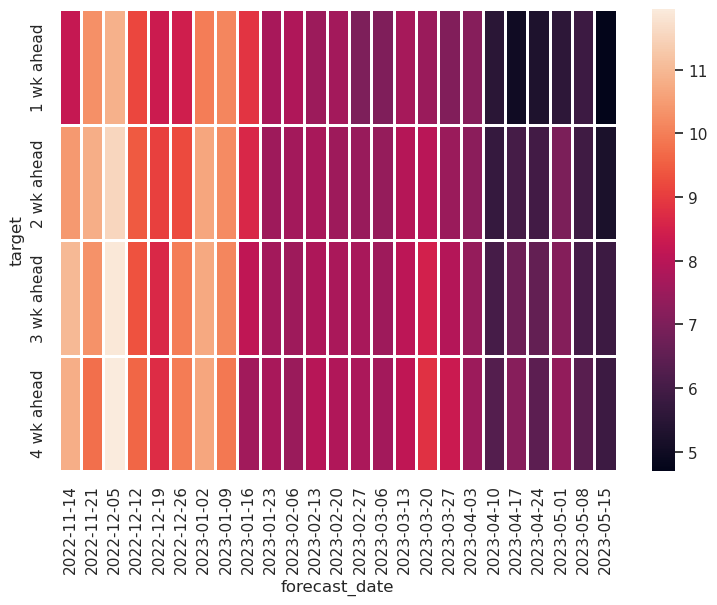

In [152]:
tp = wis_total[wis_total["location"]=="US"].pivot(values="wis_total", index="target", columns="forecast_date")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

/nas/longleaf/home/chadi/.conda/envs/diffusion_torch/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/nas/longleaf/home/chadi/.conda/envs/diffusion_torch/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<AxesSubplot: xlabel='forecast_date', ylabel='location'>

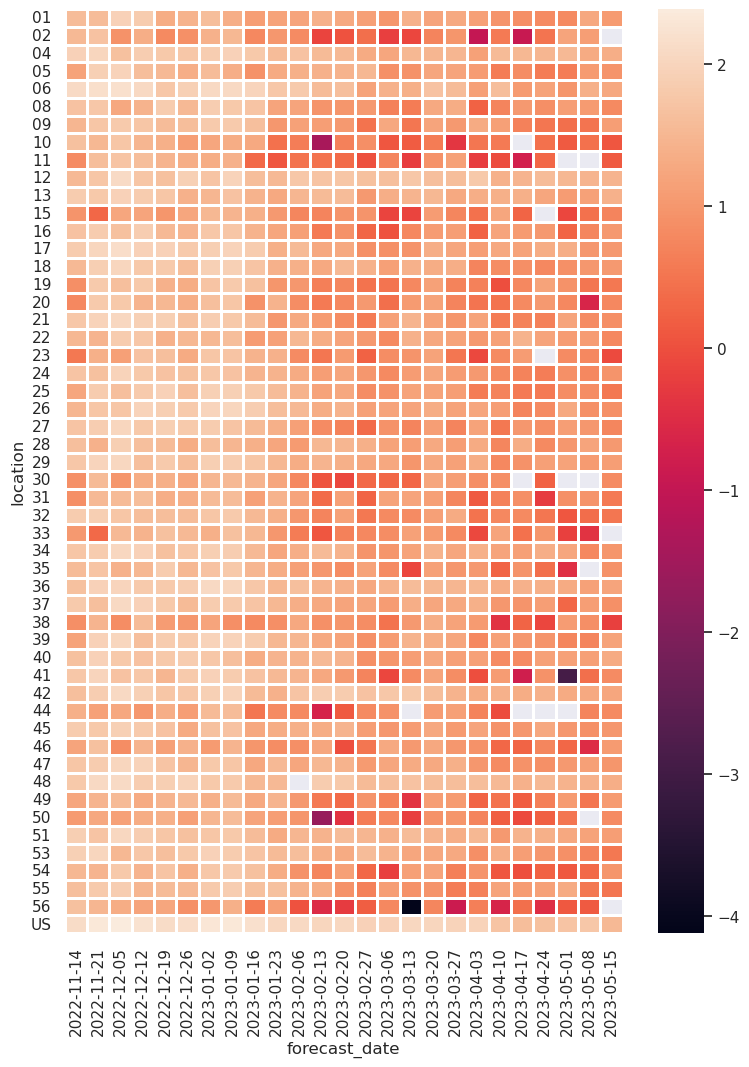

In [156]:
tp = wis_total[wis_total["target"]=="1 wk ahead"].pivot(values="wis_total", index="location", columns="forecast_date")
tp = np.log(tp)
f, ax = plt.subplots(figsize=(9, 12))
sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [159]:
# tp = wis_total.pivot(values="wis_total", index="location", columns=["forecast_date","target"])
# tp = np.log(tp)
# f, ax = plt.subplots(figsize=(12, 12), dpi=300)
# sns.heatmap(np.log(tp), annot=False, fmt="", linewidths=1, ax=ax)

In [65]:
scoring.weighted_interval_score?

Signature:
scoring.weighted_interval_score(
    observations,
    alphas,
    q_dict,
    weights=None,
    percent=False,
    check_consistency=True,
)
Docstring:
Compute weighted interval scores for an array of observations and a number of different predicted intervals.

This function implements the WIS-score (2). A dictionary with the respective (alpha/2)
and (1-(alpha/2)) quantiles for all alpha levels given in `alphas` needs to be specified.

Parameters
----------
observations : array_like
    Ground truth observations.
alphas : iterable
    Alpha levels for (1-alpha) intervals.
q_dict : dict
    Dictionary with predicted quantiles for all instances in `observations`.
weights : iterable, optional
    Corresponding weights for each interval. If `None`, `weights` is set to `alphas`, yielding the WIS^alpha-score.
percent: bool, optional
    If `True`, score is scaled by absolute value of observations to yield the double absolute percentage error. Default is `False`.
check_consistency